In [33]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mpl

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,6

from load_data import load_contracts
from sampling import dollar_bars, daily_bars

# 14.1

A strategy exhibits a high turnover, high leverage, and high number of bets, with a short holding period, low return on execution costs, and a high Sharpe ratio. Is it likely to have large capacity? What kind of strategy do you think it is?

**A: Sounds like something akin to a statistical arbitrage strategy on a smaller number of instruments, such as futures. Strategies with short holding periods and high turnover generally tend to have low capacities.**

# 14.2

On the dollar bars dataset for E-mini S&P 500 futures, compute

* a) HHI index on positive returns
* b) HHI index on negative returns
* c) HHI index on time between bars
* d) The 95-percentile DD
* e) The 95-percentile TuW
* f) Annualized average return
* g) Average returns from hits (positive returns)
* h) Average returns from misses (negative returns)
* i) Annualized SR
* j) Information ratio, where the benchmark is the risk-free rate
* k) PSR
* l) DSR, where we assume there were 100 trials, and the variance of the trials' SR was 0.5

In [2]:
es_contracts = load_contracts('@ES').truncate(before='2017-1-1')

In [3]:
dbars = dollar_bars(es_contracts, 1000000000)

In [14]:
def get_stats(series, rf_yearly_return=0.00):
    yrs_in_ser = (series.index[-1] - series.index[0]).days / 365
    obs_per_year = len(series) / yrs_in_ser
    dd, tuw = computeDD_TuW(series)

    returns = series.pct_change()[1:]
    total_return = ((1 + returns).cumprod().iloc[-1] - 1)
    
    rf_period_returns = rf_yearly_return / obs_per_year

    return {
        'rHHIPos': getHHI(returns[returns >= 0]),
        'rHHINeg': getHHI(returns[returns < 0]),
        'tHHI': getHHI(returns.groupby(pd.Grouper(freq='M')).count()),
        'dd95th': np.percentile(dd, 95),
        'tuw95th': np.percentile(tuw, 95),
        'ann_return': total_return / yrs_in_ser,
        'avg_return_hits': returns[returns >= 0].mean(),
        'avg_return_misses': returns[returns < 0].mean(),
        'ann_sharpe': np.sqrt(obs_per_year) * returns.mean() / returns.std(),
        'ann_information_ratio': np.sqrt(obs_per_year) * (returns.mean() - rf_period_returns) / returns.std()
    }

def getHHI(betRet):
    if betRet.shape[0] <= 2:
        return np.nan
    wght = betRet / betRet.sum()
    hhi = (wght**2).sum()
    hhi = (hhi - betRet.shape[0] ** -1) / (1.0 - betRet.shape[0] ** -1)
    return hhi


def computeDD_TuW(series, dollars=False):
    # compute series of drawdowns and the time under water associated with them
    df0 = series.to_frame('pnl')
    df0['hwm'] = series.expanding().max()
    df1 = df0.groupby('hwm').min().reset_index()
    df1.columns = ['hwm', 'min']
    df1.index = df0['hwm'].drop_duplicates(keep='first').index
    df1 = df1[df1['hwm'] > df1['min']]
    if dollars:
        dd = df1['hwm'] - df1['min']
    else:
        dd = 1 - df1['min'] / df1['hwm']
    tuw = ((df1.index[1:] - df1.index[:-1]) / np.timedelta64(1, 'Y')).values # in years
    tuw = pd.Series(tuw, index=df1.index[:-1])
    return dd, tuw

get_stats(dbars['Close'], 0.015)


{'ann_information_ratio': 0.8031419312703149,
 'ann_return': 0.13022942020827788,
 'ann_sharpe': 0.9187046149534217,
 'avg_return_hits': 0.003013915357033664,
 'avg_return_misses': -0.0032678142122765583,
 'dd95th': 0.05700825382941044,
 'rHHINeg': 0.0007544096935836607,
 'rHHIPos': 0.0006160043025995248,
 'tHHI': 0.0027732600439860644,
 'tuw95th': 0.17785634049828378}

# 14.3.a

Consider a strategy that is long one futures contract on even years, and is short one futures contract on odd years.

Repeat the calculations from exercise 2.

In [15]:
series = pd.Series(index=dbars.index)
series[series.index.year % 2 != 0] = 1
series[series.index.year % 2 == 0] = -1


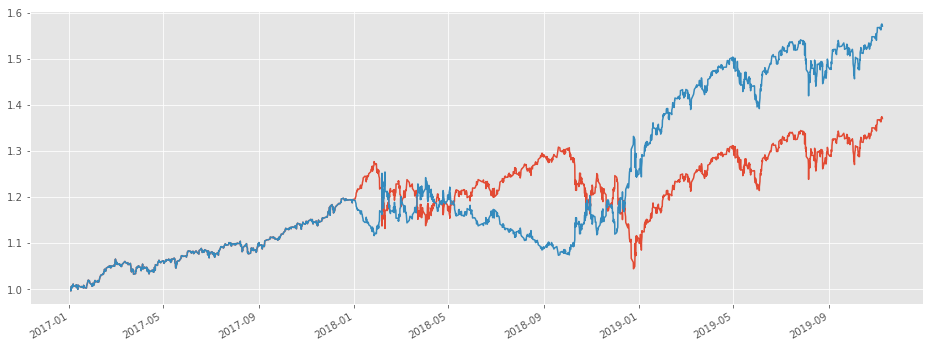

In [16]:
returns = dbars['Close'].pct_change()
long_short_returns = returns * series

reg_pnl = (1 + returns).cumprod()[1:]
strat_pnl = (1 + long_short_returns).cumprod()[1:]
reg_pnl.plot()
strat_pnl.plot();

In [17]:
get_stats(strat_pnl, 0.015)

{'ann_information_ratio': 1.1711684339746886,
 'ann_return': 0.20028988683961113,
 'ann_sharpe': 1.2867282233743575,
 'avg_return_hits': 0.0031285352891812397,
 'avg_return_misses': -0.003134265651482499,
 'dd95th': 0.06370056133354067,
 'rHHINeg': 0.0007395923828325928,
 'rHHIPos': 0.0006321610656659775,
 'tHHI': 0.0027786614941559943,
 'tuw95th': 0.12288905468436859}

# 14.3.b

Consider a strategy that is long one futures contract on even years, and is short one futures contract on odd years.

What is the correlation to the underlying?

In [20]:
print("For this short backtest the correlation is {:.2f}.".format(long_short_returns.corr(returns)))


For this short backtest the correlation is -0.15.


# 14.4

The results from a 2-year backtest are that monthly returns have a mean of 3.6%, and a standard deviation of 0.079%.

What is the SR? What is the annuallized SR?

In [22]:
monthly_returns = 0.036
std = 0.079
sharpe = monthly_returns / std
ann_sharpe = np.sqrt(12) * sharpe
print("The SR is {:.2f}".format(sharpe))
print("The annualized SR is {:.2f}".format(ann_sharpe))


The SR is 0.46
The annualized SR is 1.58


# 14.5.a

Following on exercise 1:

The returns have a skewness of 0 and a kurtosis of 3. What is the PSR?

In [25]:
from stats import psr
print("The PSR is {:.2f}.".format(psr(sharpe, 12, 0, 3)))

The PSR is 0.92.


# 14.5.b

Following on exercise 1:

The returns have a skewness of -2.448 and a kurtosis of 10.164. What is the PSR?

In [26]:
print("The PSR is {:.2f}.".format(psr(sharpe, 12, -2.448, 10.164)))

The PSR is 0.83.


# 14.6

What would be the PSR from 2.b, if the backtest had been for a length of 3 years?

In [28]:
print("The PSR is {:.2f}.".format(psr(sharpe, 12*3, -2.448, 10.164)))

The PSR is 0.95.


# 14.7.a

A 5-year backtest has an annualized SR of 2.5, computed on daily returns. The skewness is -3 and the kurtosis is 10.

What is the PSR?

In [30]:
print("The PSR is {:.2f}.".format(psr(2.5, 252*5, -3, 10)))

The PSR is 1.00.


# 14.7.b

A 5-year backtest has an annualized SR of 2.5, computed on daily returns. The skewness is -3 and the kurtosis is 10.

In order to find that best result, 100 trials were conducted. The variance of the Sharpe ratios on those trials is 0.5. What is the DSR?

In [40]:
from stats import dsr

print("The DSR is {:.2f}.".format(dsr(2.5, 0.5, 100, 252*5, -3, 10)))

The DSR is 1.00.
